In [9]:
import os
import requests
import aiohttp
import asyncio
import nest_asyncio
import pandas as pd
import time
import scrapy
from scrapy_playwright.page import PageMethod
from bs4 import BeautifulSoup
import nest_asyncio
import glob
import numpy as np

In [10]:
Fresh_Leads = pd.read_excel("Fresh_Leads.xlsx")
is_unique = Fresh_Leads['UEN'].is_unique
print("Is UEN unique?:", is_unique)


Is UEN unique?: True


In [11]:
Fresh_Leads = pd.read_excel("Fresh_Leads.xlsx")

In [12]:
# '201841356N' in df['UEN'].values

In [13]:
Fresh_Leads.shape

(255, 10)

In [14]:
count_not_nan = Fresh_Leads["Phones"].notna().sum()
print(count_not_nan)

53


In [15]:

Fresh_Leads_formatted = pd.DataFrame(columns=[
    "ePOS Code",
    "Company Code",
    "Date",
    "ACRA REGISTERED NAME",
    "Brand/Deal Name/Business Name",
    "Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client",
    "Tele Sales or MR (For KPI - Internal)",
    "Name of the Market Researcher",
    "Original Source (Marketing)",
    "Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",
    "Company Registration date / Date Established",
    "Company Registration Number (UEN)",
    "Primary SSIC Code",
    "Secondary SSIC Code",
    "Hubspot ID (Company)",
    "Hubspot ID(Deal)",
    "Hubspot ID(Contact)",
    "Website URL",
    "Business Type",
    "Facebook Page",
    "Instagram URL",
    "Linkedin URL",
    "Tik Tok URL",
    "Ownership Type",
    "Parent Industry Type",
    "Industry Type",
    "Sub Industry",
    "Business model",
    "Presence of Multiple Outlets",
    "Number of Outlets (Write in #)",
    "Region",
    "Planning Area",
    "Business Location Type",
    "Registered Address (Block & Street)",
    "Registered Address  (Unit #)",
    "Registered Address  (Postal code)",
    "Operational Address \n(Block & Street)",
    "Operational Address \n(Unit #)",
    "Operational Address \n(Postal Code)",
    "Operational Address Type",
    "First Name",
    "Last Name",
    "PIC Name 1 Designation",
    "PIC NAME 1 Contact Number",
    "PIC 1 email address",
    "First Name 2",
    "Last Name 2",
    "PIC Name 2 Designation",
    "PIC NAME 2 Contact Number",
    "PIC 2 email address",
    "First Name 3",
    "Last Name 3",
    "PIC Name Designation 3",
    "PIC NAME 3 Contact Number",
    "PIC 3 email address",
    "FB/Insta/Tik Tok/Linkedin Contact",
    "Current ePOS Client ?",
    "If ePOS Client, which product they are using?",
    "Is this deal part of the Gov List?",
    "Source from Market Researcher",
    "Contact Number from Lusha?",
    "Phone number Verified ?"
])

Fresh_Leads_formatted.head()


,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?


In [16]:
# Define the mapping from Fresh_Leads -> Fresh_Leads_formatted
cols_map = {
    "Phones": "PIC NAME 1 Contact Number",
    "Emails": "PIC 1 email address",
    "Website": "Website URL",
    "Facebook": "Facebook Page",
    "Instagram": "Instagram URL",
    "TikTok": "Tik Tok URL",
    "LinkedIn": "Linkedin URL",
    "UEN": "Company Registration Number (UEN)"
}

# Loop only over pairs where destination column ALREADY exists
for src_col, dest_col in cols_map.items():
    if src_col in Fresh_Leads.columns and dest_col in Fresh_Leads_formatted.columns:
        Fresh_Leads_formatted[dest_col] = Fresh_Leads[src_col].values
    else:
        print(f"⚠️ Skipped: {src_col} → {dest_col} (missing in one of the DataFrames)")


In [17]:
# -------------------------------------------------------------
# Folder containing your CSVs
# -------------------------------------------------------------
folder_path = "Acra_Data"

# Get all CSV file paths inside the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and combine all CSVs
# Using low_memory=False to avoid DtypeWarning for mixed types
df = pd.concat((pd.read_csv(f, low_memory=False) for f in csv_files), ignore_index=True)

# -------------------------------------------------------------
# Convert all column names to uppercase
# -------------------------------------------------------------
df.columns = df.columns.str.upper()


# -------------------------------------------------------------
# Select relevant columns (now in uppercase)
# -------------------------------------------------------------
acra_data = df[[
    "UEN",
    "ENTITY_NAME",
    "BUSINESS_CONSTITUTION_DESCRIPTION",
    "ENTITY_TYPE_DESCRIPTION",
    "ENTITY_STATUS_DESCRIPTION",
    "REGISTRATION_INCORPORATION_DATE",
    "PRIMARY_SSIC_CODE",
    "STREET_NAME",
    "POSTAL_CODE"
]].copy()

# -------------------------------------------------------------
# Convert to proper data types
# -------------------------------------------------------------
acra_data['UEN'] = acra_data['UEN'].astype('string')
acra_data['ENTITY_NAME'] = acra_data['ENTITY_NAME'].astype('string')
acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'] = acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'].astype('string')
acra_data['ENTITY_TYPE_DESCRIPTION'] = acra_data['ENTITY_TYPE_DESCRIPTION'].astype('string')
acra_data['ENTITY_STATUS_DESCRIPTION'] = acra_data['ENTITY_STATUS_DESCRIPTION'].astype('string')
acra_data['REGISTRATION_INCORPORATION_DATE'] = pd.to_datetime(acra_data['REGISTRATION_INCORPORATION_DATE'], errors='coerce')

# -------------------------------------------------------------
# Clean string columns — trim, remove extra spaces, uppercase
# -------------------------------------------------------------
for col in [
    'UEN',
    'ENTITY_NAME',
    'BUSINESS_CONSTITUTION_DESCRIPTION',
    'ENTITY_TYPE_DESCRIPTION',
    'ENTITY_STATUS_DESCRIPTION',
    'STREET_NAME',
    'POSTAL_CODE'
]:
    acra_data[col] = (
        acra_data[col]
        .fillna('')
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.upper()
    )

# -------------------------------------------------------------
# Replace placeholders with NaN for standardization
# -------------------------------------------------------------
acra_data.replace(['NA', 'N/A', '-', ''], np.nan, inplace=True)

# -------------------------------------------------------------
# Convert registration date to dd-mm-yyyy string (optional)
# -------------------------------------------------------------
acra_data['REGISTRATION_INCORPORATION_DATE'] = acra_data['REGISTRATION_INCORPORATION_DATE'].dt.strftime('%d-%m-%Y')

# -------------------------------------------------------------
# Filter only live entities (LIVE COMPANY or LIVE)
# -------------------------------------------------------------
acra_data = acra_data[
    acra_data['ENTITY_STATUS_DESCRIPTION'].isin(['LIVE COMPANY', 'LIVE'])
].reset_index(drop=True)

# -------------------------------------------------------------
# Exclude specific PRIMARY_SSIC_CODE values
# -------------------------------------------------------------
exclude_codes = [
    46900, 47719, 47749, 47539, 47536, 56123,
    10711, 10712, 10719, 10732, 10733, 93209
]

acra_data = acra_data[~acra_data['PRIMARY_SSIC_CODE'].isin(exclude_codes)].reset_index(drop=True)

In [18]:
# --- CONFIG ---
file_path = "./SSIC_Code/mapped_ssic_code.xlsx"

# --- LOAD DATA ---
mapped_ssic_code = pd.read_excel(file_path)

# --- STANDARDIZE COLUMN NAMES ---
# Uppercase, strip spaces, replace spaces with underscores
mapped_ssic_code.columns = (
    mapped_ssic_code.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
)

# --- KEEP ONLY DESIRED COLUMNS ---
columns_to_keep = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "SSIC_CODES", "DESCRIPTION"]
mapped_ssic_code = mapped_ssic_code[columns_to_keep].copy()

# --- CLEAN SSIC_CODES COLUMN ---
mapped_ssic_code["SSIC_CODES"] = (
    pd.to_numeric(mapped_ssic_code["SSIC_CODES"], errors="coerce")  # safely convert to numeric
    .fillna(0)
    .astype(int)
)

# --- CLEAN TEXT COLUMNS ---
text_cols = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "DESCRIPTION"]
mapped_ssic_code[text_cols] = mapped_ssic_code[text_cols].apply(
    lambda col: col.astype(str).str.strip().str.title()
)

# --- REMOVE DUPLICATES & RESET INDEX ---
mapped_ssic_code = mapped_ssic_code.drop_duplicates().reset_index(drop=True)

mapped_ssic_code.head()


,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,SSIC_CODES,DESCRIPTION
0,Retail,Retail,Fashion & Apparel,47711,Retail Sale Of Clothing For Adults
1,Retail,Retail,Fashion & Apparel,47712,Retail Sale Of Children And Infants' Clothing
2,Retail,Retail,Fashion & Apparel,47715,Retail Sale Of Sewing And Clothing Accessories
3,Retail,Retail,Fashion & Apparel,47719,"Retail Sale Of Clothing, Footwear And Leather ..."
4,Retail,Retail,Fashion & Apparel,47510,Retail Sale Of Textiles


In [19]:
# Convert PRIMARY_SSIC_CODE to int
acra_data["PRIMARY_SSIC_CODE"] = (
    pd.to_numeric(acra_data["PRIMARY_SSIC_CODE"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# Merge based on SSIC code
acra_data_filtered = acra_data.merge(
    mapped_ssic_code,
    how="left",
    left_on="PRIMARY_SSIC_CODE",
    right_on="SSIC_CODES"
)

# Optional: drop the duplicate 'SSIC CODES' column (keep only PRIMARY_SSIC_CODE)
acra_data_filtered = acra_data_filtered.drop(columns=["SSIC_CODES"], errors="ignore")
acra_data_filtered

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,FISHERY PORT ROAD,619742,Others,Wholesale Trade,"Food, Beverages & Tobacco","Wholesale Of Livestock, Meat, Poultry, Eggs An..."
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,SIMS AVENUE,387509,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,ANG MO KIO INDUSTRIAL PARK 2A,568049,Others,Manufacturing,Other Specialised Manufacturing & Distribution,Other Manufacturing Industries N.E.C.
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,JELLICOE ROAD,208767,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,WOODLANDS STREET 12,738623,Retail,Retail,Fashion & Apparel,Retail Sale Of Clothing For Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537323,T25LL0518K,ZEUS BARBERS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,16-05-2025,96021,KELANTAN LANE,200031,Services,Services,Hair Salons & Barbershops,Hairdressing Salons/Shops
537324,T25LL0858C,ZENSE SPACE LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,01-08-2025,43301,YISHUN INDUSTRIAL STREET 1,768161,Others,Built Environment & Infrastructure,Construction,Renovation Contractors
537325,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,SIN MING LANE,573969,Others,"Finance, Legal & Real Estate","Legal, Accounting & Consultancy Activities",Management Consultancy Services N.E.C.
537326,T25LL1049B,ZHONG XIN TRAVEL LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,08-09-2025,79102,JALAN BAHAGIA,320034,Others,"Tourism, Agency",Travel Agencies & Tour Operators,Travel Agencies And Tour Operators (Mainly Out...


In [20]:
# ensure consistent column name format
Fresh_Leads_formatted.columns = Fresh_Leads_formatted.columns.str.strip()
acra_data_filtered.columns = acra_data_filtered.columns.str.strip()

# merge only the columns you need
# KEY FIX: Use left_on and right_on since the UEN column names are different
merged = Fresh_Leads_formatted.merge(
    acra_data_filtered[
        [
            "UEN",
            "ENTITY_NAME",
            "PRIMARY_SSIC_CODE",
            "REGISTRATION_INCORPORATION_DATE",
            "ENTITY_TYPE_DESCRIPTION",
            "PARENT_INDUSTRY",
            "SUB_INDUSTRY"
        ]
    ],
    left_on="Company Registration Number (UEN)",
    right_on="UEN",
    how="left"
)

# now assign values to the right columns (only if they exist in formatted)
mapping = {
    "ENTITY_NAME": ["ACRA REGISTERED NAME", "Brand/Deal Name/Business Name"],
    "PRIMARY_SSIC_CODE": ["Primary SSIC Code"],
    "REGISTRATION_INCORPORATION_DATE": ["Company Registration date / Date Established"],
    "ENTITY_TYPE_DESCRIPTION": ["Ownership Type"],
    "PARENT_INDUSTRY": ["Parent Industry Type"],
    "SUB_INDUSTRY": ["Sub Industry"]
}

for src, dest_list in mapping.items():
    for dest in dest_list:
        if dest in merged.columns:
            merged[dest] = merged[src]
        else:
            print(f"⚠️ Skipped: {src} → {dest} (column missing in Fresh_Leads_formatted)")

# Drop the duplicate UEN column (optional - keeps things cleaner)
if "UEN" in merged.columns:
    merged = merged.drop(columns=["UEN"])

Fresh_Leads_formatted = merged

In [21]:
# Clean up: Drop the extra columns from acra_data_filtered to keep only original columns
columns_to_drop = ["ENTITY_NAME", "PRIMARY_SSIC_CODE", "REGISTRATION_INCORPORATION_DATE", 
                   "ENTITY_TYPE_DESCRIPTION", "PARENT_INDUSTRY", "SUB_INDUSTRY"]

Fresh_Leads_formatted = Fresh_Leads_formatted.drop(columns=columns_to_drop, errors='ignore')

print(f"✓ Successfully cleaned up! Shape: {Fresh_Leads_formatted.shape}")
print(f"Columns: {len(Fresh_Leads_formatted.columns)}")
Fresh_Leads_formatted.head()

✓ Successfully cleaned up! Shape: (255, 62)
Columns: 62


,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
0,NaN,NaN,NaN,BELL 1 SINGAPORE PTE. LTD.,BELL 1 SINGAPORE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NUU&NII PTE. LTD.,NUU&NII PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,CLOUD FRONTIER ASIA PTE. LTD.,CLOUD FRONTIER ASIA PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,GOLDEN GARLAND COMMUNICATION PTE. LTD.,GOLDEN GARLAND COMMUNICATION PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,XINYUAN SHOES PTE. LTD.,XINYUAN SHOES PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analysis

In [22]:
# Count non-NaN values in the phone column
phone_count = Fresh_Leads_formatted["PIC NAME 1 Contact Number"].notna().sum()
print(f"Number of non-NaN phone numbers: {phone_count}")

# Alternative: show some stats
print(f"\nTotal rows: {len(Fresh_Leads_formatted)}")
print(f"Non-NaN phones: {phone_count}")
print(f"NaN phones: {Fresh_Leads_formatted['PIC NAME 1 Contact Number'].isna().sum()}")
print(f"Percentage with phones: {(phone_count / len(Fresh_Leads_formatted) * 100):.1f}%")

Number of non-NaN phone numbers: 53

Total rows: 255
Non-NaN phones: 53
NaN phones: 202
Percentage with phones: 20.8%


In [23]:
Fresh_Leads_formatted

,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
0,NaN,NaN,NaN,BELL 1 SINGAPORE PTE. LTD.,BELL 1 SINGAPORE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NUU&NII PTE. LTD.,NUU&NII PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,CLOUD FRONTIER ASIA PTE. LTD.,CLOUD FRONTIER ASIA PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,GOLDEN GARLAND COMMUNICATION PTE. LTD.,GOLDEN GARLAND COMMUNICATION PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,XINYUAN SHOES PTE. LTD.,XINYUAN SHOES PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,NaN,NaN,NaN,ELEVARE PTE. LTD.,ELEVARE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,NaN,GILY PTE. LTD.,GILY PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,NaN,NaN,NaN,AI WELLNESS PTE. LTD.,AI WELLNESS PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,NaN,NaN,NaN,INSTANTFORCE PTE. LTD.,INSTANTFORCE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
import pandas as pd

Fresh_Leads_formatted['Date'] = pd.Timestamp.today().normalize()


In [25]:
Fresh_Leads_formatted

,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
0,NaN,NaN,2025-11-05,BELL 1 SINGAPORE PTE. LTD.,BELL 1 SINGAPORE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2025-11-05,NUU&NII PTE. LTD.,NUU&NII PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2025-11-05,CLOUD FRONTIER ASIA PTE. LTD.,CLOUD FRONTIER ASIA PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2025-11-05,GOLDEN GARLAND COMMUNICATION PTE. LTD.,GOLDEN GARLAND COMMUNICATION PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2025-11-05,XINYUAN SHOES PTE. LTD.,XINYUAN SHOES PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,NaN,NaN,2025-11-05,ELEVARE PTE. LTD.,ELEVARE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,2025-11-05,GILY PTE. LTD.,GILY PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,NaN,NaN,2025-11-05,AI WELLNESS PTE. LTD.,AI WELLNESS PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,NaN,NaN,2025-11-05,INSTANTFORCE PTE. LTD.,INSTANTFORCE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


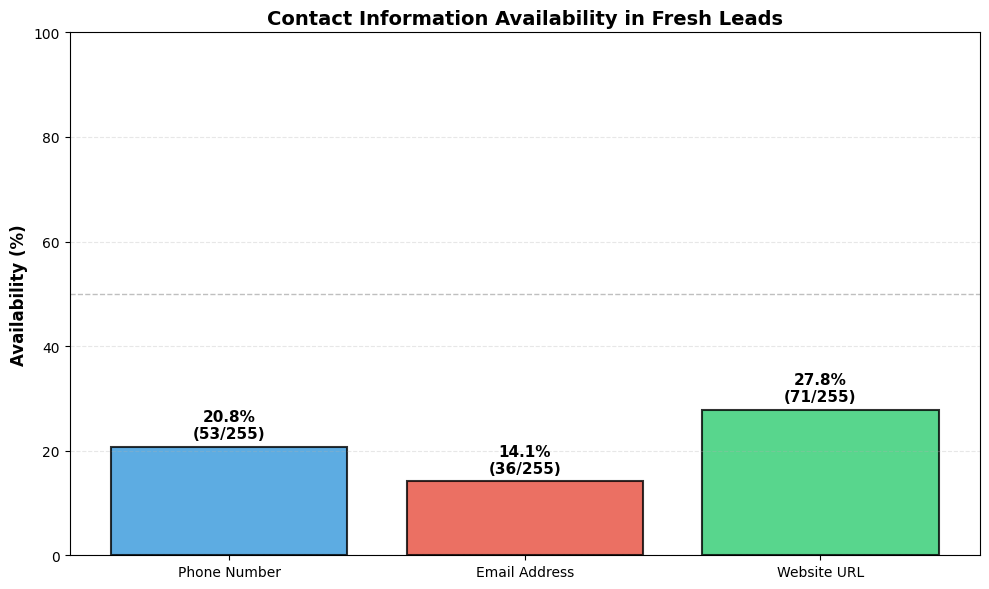


📊 Summary:
  Phone Numbers:  20.8% (53/255)
  Email Addresses: 14.1% (36/255)
  Website URLs:    27.8% (71/255)


In [26]:
import matplotlib.pyplot as plt

# Calculate percentages and counts for each field
total_rows = len(Fresh_Leads_formatted)

phone_count = Fresh_Leads_formatted["PIC NAME 1 Contact Number"].notna().sum()
email_count = Fresh_Leads_formatted["PIC 1 email address"].notna().sum()
website_count = Fresh_Leads_formatted["Website URL"].notna().sum()

phone_pct = (phone_count / total_rows) * 100
email_pct = (email_count / total_rows) * 100
website_pct = (website_count / total_rows) * 100

# Data for plotting
fields = ['Phone Number', 'Email Address', 'Website URL']
percentages = [phone_pct, email_pct, website_pct]
counts = [phone_count, email_count, website_count]
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(fields, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add percentage and count labels on top of bars
for bar, pct, count in zip(bars, percentages, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{pct:.1f}%\n({count}/{total_rows})',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Customize the chart
plt.ylabel('Availability (%)', fontsize=12, fontweight='bold')
plt.title('Contact Information Availability in Fresh Leads', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add a horizontal line at 50%
plt.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary with counts
print(f"\n📊 Summary:")
print(f"  Phone Numbers:  {phone_pct:.1f}% ({phone_count}/{total_rows})")
print(f"  Email Addresses: {email_pct:.1f}% ({email_count}/{total_rows})")
print(f"  Website URLs:    {website_pct:.1f}% ({website_count}/{total_rows})")

In [27]:
# Filter rows where any of the 3 columns is not null
Fresh_Leads_formatted_filtered_PhoneNumber= Fresh_Leads_formatted[
    Fresh_Leads_formatted["PIC NAME 1 Contact Number"].notna()
]

Fresh_Leads_formatted_filtered_PhoneNumber.to_csv("Fresh_Leads_formatted_filtered_PhoneNumber.csv", index=False)


In [28]:
Fresh_Leads_formatted.shape

(255, 62)

In [30]:
Fresh_Leads_formatted.tail(30)

,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
225,NaN,NaN,2025-11-05,OUYA CERAMICS PTE. LTD.,OUYA CERAMICS PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,2025-11-05,CSOAR TRADING PTE. LTD.,CSOAR TRADING PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,2025-11-05,MONSOON UMBRELLA PTE. LTD.,MONSOON UMBRELLA PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,2025-11-05,FULCRUM FOODS PTE. LTD.,FULCRUM FOODS PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,NaN,NaN,2025-11-05,CH INDUSTRY PTE. LTD.,CH INDUSTRY PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,NaN,2025-11-05,LENS HOME SINGAPORE PTE. LTD.,LENS HOME SINGAPORE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,NaN,2025-11-05,AP PARTNERS ADVISORY PTE. LTD.,AP PARTNERS ADVISORY PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,NaN,NaN,2025-11-05,KAMI BEAUTY PTE. LTD.,KAMI BEAUTY PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,NaN,2025-11-05,SINCOTTE PTE. LTD.,SINCOTTE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,NaN,NaN,2025-11-05,CRAFT AXIS PTE. LTD.,CRAFT AXIS PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Fresh_Leads_formatted

In [36]:
Fresh_Leads_formatted_x = Fresh_Leads_formatted[["ACRA REGISTERED NAME", "Company Registration Number (UEN)", "PIC NAME 1 Contact Number"]]
Fresh_Leads_formatted_x

,ACRA REGISTERED NAME,Company Registration Number (UEN),PIC NAME 1 Contact Number
0,BELL 1 SINGAPORE PTE. LTD.,201819442H,['+6562590183']
1,NUU&NII PTE. LTD.,202534677Z,NaN
2,CLOUD FRONTIER ASIA PTE. LTD.,201925464M,NaN
3,GOLDEN GARLAND COMMUNICATION PTE. LTD.,202108485W,NaN
4,XINYUAN SHOES PTE. LTD.,202519922K,NaN
...,...,...,...
250,ELEVARE PTE. LTD.,202318375R,['+6580815245']
251,GILY PTE. LTD.,202449408H,['+6567484155']
252,AI WELLNESS PTE. LTD.,202243688N,['+6593372012']
253,INSTANTFORCE PTE. LTD.,202401375G,['+6580113218']


In [ ]:
# Fresh_Leads_formatted.to_csv("Fresh_Leads_formatted.csv", index=False)
